# Data Augmentation Study

This notebook studies the impact of data augmentation on our training 
process. We will use the classic VGG-16 architecture for comparison.

Reference:
 - https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
 - https://towardsdatascience.com/cnn-architectures-a-deep-dive-a99441d18049


In [1]:
from gc import collect
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
from h5py import File
from pandas import read_csv
from sklearn.metrics import accuracy_score, classification_report, \
    confusion_matrix
from tensorflow.config.experimental import list_physical_devices, \
    set_memory_growth
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, \
    LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPool2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.random import set_random_seed


### Model Creation Function

In [2]:
# VGG-16
def create_model(input_shape: Tuple[int, int, int], num_classes: int) -> Model:
    inputs = Input(shape=input_shape)
    
    layer = Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding="same", 
                   activation="relu", kernel_initializer="he_normal",
                   bias_initializer="he_normal")(inputs)
    layer = Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding="same", 
                   activation="relu", kernel_initializer="he_normal",
                   bias_initializer="he_normal")(layer)
    layer = MaxPool2D(pool_size=(2, 2), strides=2)(layer)

    layer = Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding="same", 
                   activation="relu", kernel_initializer="he_normal",
                   bias_initializer="he_normal")(layer)
    layer = Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding="same", 
                   activation="relu", kernel_initializer="he_normal",
                   bias_initializer="he_normal")(layer)
    layer = MaxPool2D(pool_size=(2, 2), strides=2)(layer)
    
    layer = Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding="same", 
                   activation="relu", kernel_initializer="he_normal",
                   bias_initializer="he_normal")(layer)
    layer = Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding="same", 
                   activation="relu", kernel_initializer="he_normal",
                   bias_initializer="he_normal")(layer)
    layer = Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding="same", 
                   activation="relu", kernel_initializer="he_normal",
                   bias_initializer="he_normal")(layer)
    layer = MaxPool2D(pool_size=(2, 2), strides=2)(layer)
    
    layer = Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding="same", 
                   activation="relu", kernel_initializer="he_normal",
                   bias_initializer="he_normal")(layer)
    layer = Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding="same", 
                   activation="relu", kernel_initializer="he_normal",
                   bias_initializer="he_normal")(layer)
    layer = Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding="same", 
                   activation="relu", kernel_initializer="he_normal",
                   bias_initializer="he_normal")(layer)
    layer = MaxPool2D(pool_size=(2, 2), strides=2)(layer)
    
    layer = Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding="same", 
                   activation="relu", kernel_initializer="he_normal",
                   bias_initializer="he_normal")(layer)
    layer = Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding="same", 
                   activation="relu", kernel_initializer="he_normal",
                   bias_initializer="he_normal")(layer)
    layer = Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding="same", 
                   activation="relu", kernel_initializer="he_normal",
                   bias_initializer="he_normal")(layer)
    layer = MaxPool2D(pool_size=(2, 2), strides=2)(layer)
    
    layer = Flatten()(layer)
    layer = Dense(units=4096, activation="relu", 
                  kernel_initializer="he_normal",
                  bias_initializer="he_normal")(layer)
    layer = Dense(units=4096, activation="relu", 
                  kernel_initializer="he_normal",
                  bias_initializer="he_normal")(layer)
    layer = Dense(num_classes, activation="softmax")(layer)
    
    new_model = Model(inputs=inputs, outputs=layer)
    new_model.compile(optimizer=Adam(learning_rate=0.0001),
                      loss="categorical_crossentropy", metrics=["accuracy"])
    
    return new_model


### Other Functions

In [3]:
def refresh_session():
    # Call this before training a new model, to free up memory from the 
    # previous model
    clear_session()
    try:
        del model
    except NameError:
        pass
    collect()


def import_dataset(filepath: str = "./dataset.hdf5") \
        -> Tuple[np.ndarray, np.ndarray, np.ndarray, 
                 np.ndarray, np.ndarray, np.ndarray]:
    file = File(filepath, "r")
    train_data = file.get("tr_data")[()]
    val_data = file.get("val_data")[()]
    test_data = file.get("ts_data")[()]
    train_labels = file.get("tr_labels")[()]
    val_labels = file.get("val_labels")[()]
    test_labels = file.get("ts_labels")[()]
    
    return train_data, val_data, test_data, \
           train_labels, val_labels, test_labels


def get_test_results(test_model: Model, test_data: np.ndarray, 
                     test_labels: np.ndarray) -> Tuple:
    predicts = test_model.predict(test_data)
    pred_out = np.argmax(predicts, axis=1)
    test_out = np.argmax(test_labels, axis=1)
    labels = ["car", "heavy vehicles", "motorcycle"]
    
    return accuracy_score(test_out, pred_out), \
           confusion_matrix(test_out, pred_out), \
           classification_report(test_out, pred_out, target_names=labels)


def get_learn_rate(epoch: int) -> float:
    if epoch <= 10:
        lr = 1e-4
    elif epoch <= 20:
        lr = 5e-5
    elif epoch <= 30:
        lr = 1e-5
    elif epoch <= 40:
        lr = 5e-6
    else:
        lr = 1e-6
    print(f"Learning rate: {lr}")
    
    return lr



### Initialise Environment

In [4]:
# Configure tensorflow to optimise GPU utilisation
gpu_list = list_physical_devices("GPU")
for gpu in gpu_list:
    set_memory_growth(gpu, True)
del gpu_list

# Fix tensorflow random seed
set_random_seed(324)

tr_dat, val_dat, ts_dat, tr_lbls, val_lbls, ts_lbls = import_dataset()

in_shape = (tr_dat.shape[1], tr_dat.shape[2], tr_dat.shape[3])
num_cls = tr_lbls.shape[1]

lr_scheduler = LearningRateScheduler(get_learn_rate)
early_stopper = EarlyStopping(monitor="val_loss", patience=10, verbose=1, 
                              mode="min", restore_best_weights=True)

# Test data is not needed in this notebook, so free up the memory
del ts_dat
del ts_lbls
collect()


219

### Model Creation & Training

In [5]:
# No data augmentation
refresh_session()
model = create_model(in_shape, num_cls)
print(model.summary())

checkpoint = ModelCheckpoint("./trained_models/no_augmentation_best.hdf5", 
                             monitor="val_loss", verbose=0, 
                             save_best_only=True, mode="min")
logger = CSVLogger("./training_logs/no_augmentation_log.csv")

model.fit(tr_dat, tr_lbls, batch_size=32, validation_data=(val_dat, val_lbls), 
          epochs=50, verbose=2, shuffle=True, 
          callbacks=[checkpoint, logger, lr_scheduler, early_stopper])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________

In [6]:
# With data augmentation
refresh_session()
data_gen = ImageDataGenerator(
    rotation_range=45, width_shift_range=0.2, height_shift_range=0.2,
    zoom_range=0.2, horizontal_flip=True)

model = create_model(in_shape, num_cls)
print(model.summary())

checkpoint = ModelCheckpoint("./trained_models/augmented_best.hdf5", 
                             monitor="val_loss", verbose=0, 
                             save_best_only=True, mode="min")
logger = CSVLogger("./training_logs/augmented_log.csv")

model.fit_generator(
    data_gen.flow(tr_dat, tr_lbls, batch_size=32, shuffle=True), 
    steps_per_epoch=(len(tr_dat) / 32), epochs=50, verbose=2, 
    callbacks=[checkpoint, logger, lr_scheduler, early_stopper], 
    validation_data=(val_dat, val_lbls))


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0     

In [7]:
# Training phase is complete: free training data memory
del tr_dat
del tr_lbls
refresh_session()


### Data Visualisation

In [8]:
acc_scores = dict()
conf_matrices = dict()
class_reports = dict()

plt.style.use("ggplot")


#### Before Data Augmentation

Validation accuracy before augmentation: 0.595703125
Confusion Matrix:
[[ 30  96  40]
 [  8 133  32]
 [  3  28 142]]
                precision    recall  f1-score   support

           car       0.73      0.18      0.29       166
heavy vehicles       0.52      0.77      0.62       173
    motorcycle       0.66      0.82      0.73       173

      accuracy                           0.60       512
     macro avg       0.64      0.59      0.55       512
  weighted avg       0.64      0.60      0.55       512



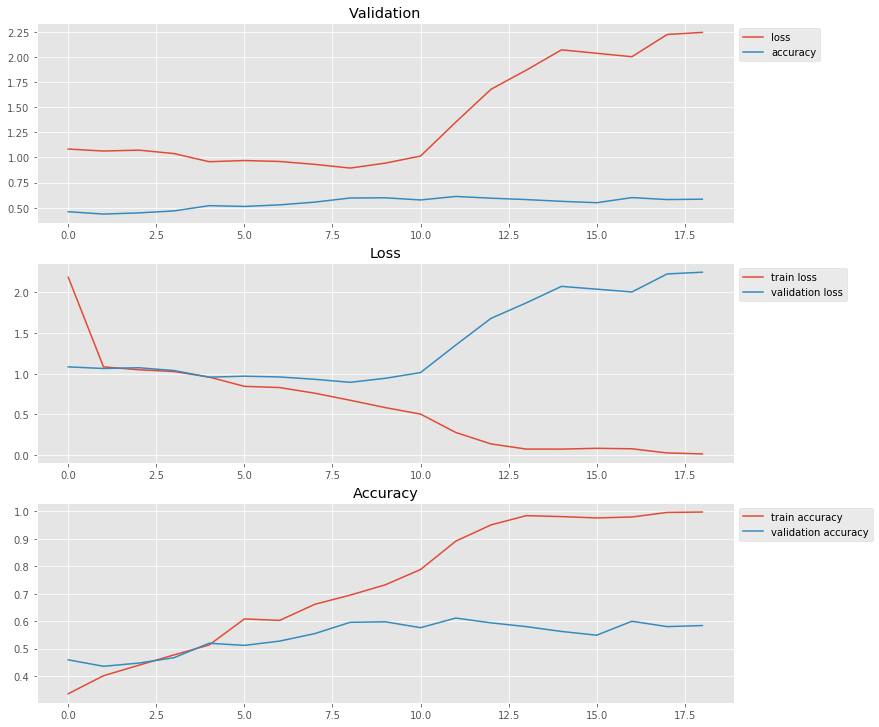

In [14]:
refresh_session()
model = load_model("./trained_models/no_augmentation_best.hdf5", compile=False)
acc_scores["unaugmented"], conf_matrices["unaugmented"], \
class_reports["unaugmented"] \
    = get_test_results(model, val_dat, val_lbls)

print(f"Validation accuracy before augmentation: {acc_scores['unaugmented']}")
print("Confusion Matrix:")
print(conf_matrices['unaugmented'])
print(class_reports['unaugmented'])

log_unaugmented = read_csv("./training_logs/no_augmentation_log.csv")

plt.figure(figsize=[12.5, 12.5])
plt.subplot(311)
plt.plot(log_unaugmented["val_loss"], label="loss")
plt.plot(log_unaugmented["val_acc"], label="accuracy")
plt.title("Validation")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

plt.subplot(312)
plt.plot(log_unaugmented["loss"], label="train loss")
plt.plot(log_unaugmented["val_loss"], label="validation loss")
plt.title("Loss")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

plt.subplot(313)
plt.plot(log_unaugmented["acc"], label="train accuracy")
plt.plot(log_unaugmented["val_acc"], label="validation accuracy")
plt.title("Accuracy")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))


#### After Data Augmentation

Validation accuracy after augmentation: 0.619140625
Confusion Matrix:
[[ 85  59  22]
 [ 42 101  30]
 [ 17  25 131]]
                precision    recall  f1-score   support

           car       0.59      0.51      0.55       166
heavy vehicles       0.55      0.58      0.56       173
    motorcycle       0.72      0.76      0.74       173

      accuracy                           0.62       512
     macro avg       0.62      0.62      0.62       512
  weighted avg       0.62      0.62      0.62       512



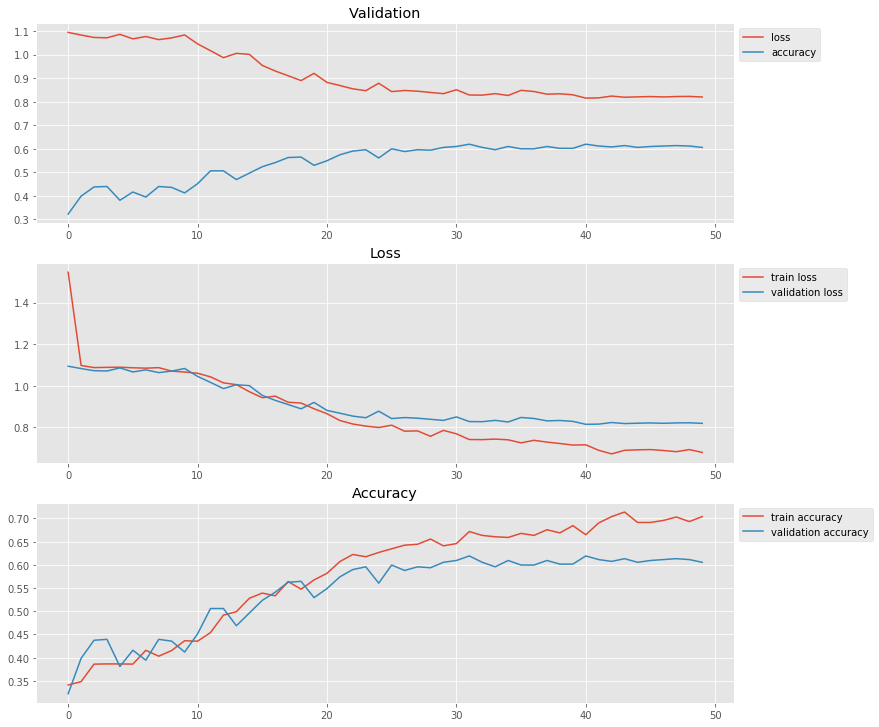

In [15]:
refresh_session()
model = load_model("./trained_models/augmented_best.hdf5", compile=False)
acc_scores["augmented"], conf_matrices["augmented"], \
class_reports["augmented"] = get_test_results(model, val_dat, val_lbls)

print(f"Validation accuracy after augmentation: {acc_scores['augmented']}")
print("Confusion Matrix:")
print(conf_matrices['augmented'])
print(class_reports['augmented'])

log_augmented = read_csv("./training_logs/augmented_log.csv")

plt.figure(figsize=[12.5, 12.5])
plt.subplot(311)
plt.plot(log_augmented["val_loss"], label="loss")
plt.plot(log_augmented["val_acc"], label="accuracy")
plt.title("Validation")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

plt.subplot(312)
plt.plot(log_augmented["loss"], label="train loss")
plt.plot(log_augmented["val_loss"], label="validation loss")
plt.title("Loss")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

plt.subplot(313)
plt.plot(log_augmented["acc"], label="train accuracy")
plt.plot(log_augmented["val_acc"], label="validation accuracy")
plt.title("Accuracy")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))


#### Cross-Model Comparison

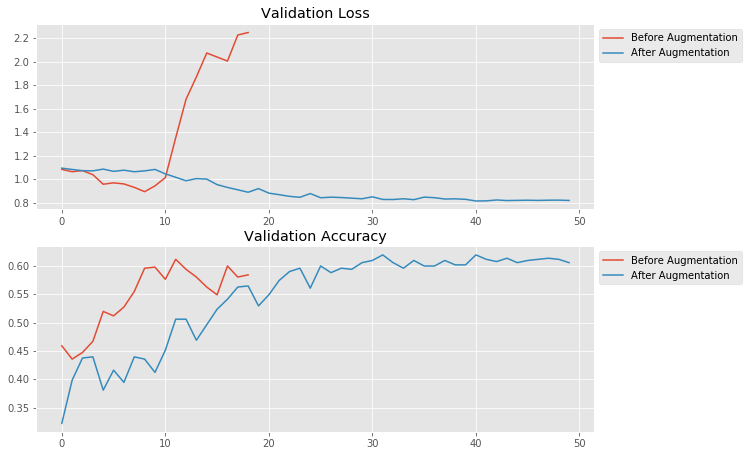

In [16]:
plt.figure(figsize=[10, 7.5])
plt.subplot(211)
plt.plot(log_unaugmented["val_loss"], label="Before Augmentation")
plt.plot(log_augmented["val_loss"], label="After Augmentation")
plt.title("Validation Loss")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

plt.subplot(212)
plt.plot(log_unaugmented["val_acc"], label="Before Augmentation")
plt.plot(log_augmented["val_acc"], label="After Augmentation")
plt.title("Validation Accuracy")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))



